In [68]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('modules loaded')

modules loaded


C:\Users\HP\AppData\Local\Temp\ipykernel_10324\1633298320.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [69]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)            
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())           
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df

In [70]:
sdir=r'C:/Users/HP/Desktop/brain/data/original'
trsplit=.9
vsplit=.05
train_df, test_df, valid_df= preprocess(sdir,trsplit, vsplit)

train_df length:  2937   test_df length:  164   valid_df length:  163
[843, 833, 811, 450]


In [71]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [72]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim(train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [73]:
max_samples= 830
min_samples=0
column='labels'
working_dir = r'./data'
img_size=(200,200)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  4
[830, 830, 811, 450]
Found 811 validated image filenames.
Found 450 validated image filenames.
Total Augmented images created=  399
[830, 830, 830, 830]


In [74]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def scalar(img):  
    img=img/127.5 -1
    return img  
    
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

classes=list(train_gen.class_indices.keys())
class_count=len(classes)
labels=test_gen.labels

test batch size:  41   test steps:  4
Found 3320 validated image filenames belonging to 4 classes.
Found 164 validated image filenames belonging to 4 classes.
Found 163 validated image filenames belonging to 4 classes.


In [ ]:
model_name='Inception_ResnetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)
                              
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('inceptionResNet.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
history = model.fit(x=train_gen,
                              epochs = 60,
                              validation_data = valid_gen,
                              shuffle=False,
                              callbacks=[EarlyStopping, model_save,rlr])

In [30]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

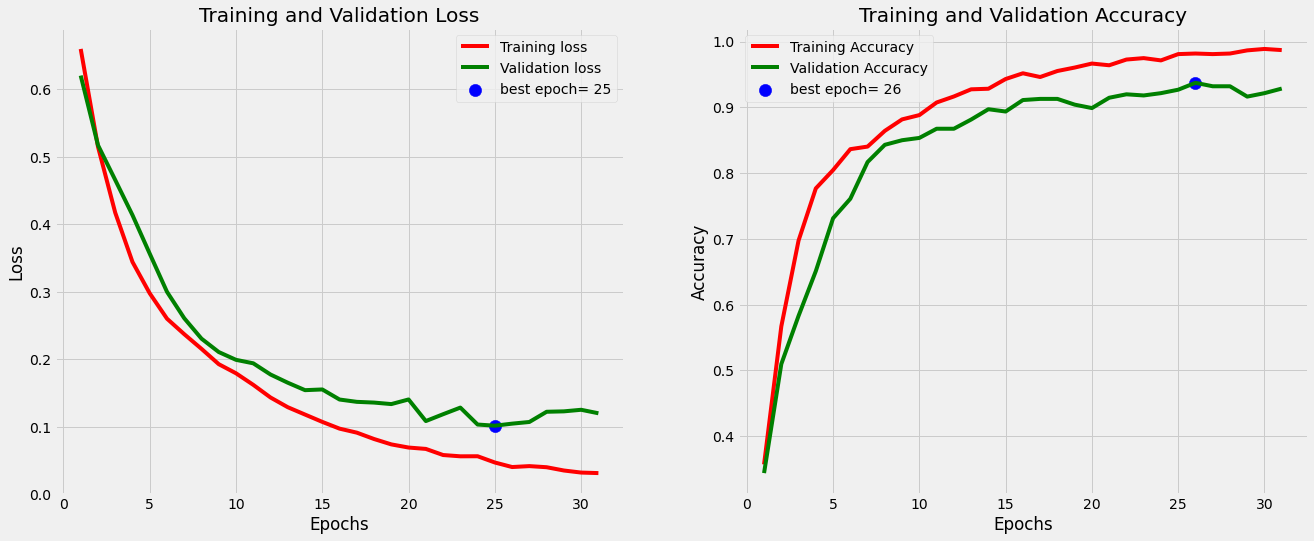

In [31]:
tr_plot(history,0)

In [61]:
finalModel=load_model('inceptionResNet.h5')

In [56]:
test_loss, test_acc = finalModel.evaluate(test_gen)
print('val acc:', test_acc)
print('val_loss:',test_loss)

4/4 [==============================] - 23s 6s/step - loss: 0.3084 - accuracy: 0.9695
val acc: 0.9695122241973877
val_loss: 0.3083786368370056


In [67]:
from sklearn.metrics import classification_report
x = list(test_df['labels'])
fields = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in range(len(x)):
    x[i] = fields.index(x[i])
x = np.array(x)
pred = finalModel.predict(test_gen)
pred = np.argmax(pred,axis=1)
predictions = pred.reshape(1,-1)[0]
print(classification_report(x, predictions, 
                            target_names = fields))

4/4 [==============================] - 30s 6s/step
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.96      0.97        47
meningioma_tumor       1.00      0.98      0.99        47
        no_tumor       0.89      0.96      0.92        25
 pituitary_tumor       0.98      0.98      0.98        45

        accuracy                           0.97       164
       macro avg       0.96      0.97      0.96       164
    weighted avg       0.97      0.97      0.97       164



In [48]:
def predict(path,model):
    input_img=plt.imread(path)
    img_size=(200,200)
    print ('Input image shape is ', input_img.shape)
    img=input_img/127.5-1 # rescale pixels
    img=cv2.resize(img, img_size) # in earlier 
    print ('the resized image has shape ', img.shape)
    plt.axis('off')
    plt.imshow(input_img)

    img=np.expand_dims(img, axis=0)
    print ('image shape after expanding dimensions is ',img.shape)
    pred=model.predict(img)
    print ('the shape of prediction is ', pred.shape)

    index=np.argmax(pred[0])
    classes=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    klass=classes[index]
    probability=pred[0][index]*100
    print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')

Input image shape is  (442, 400, 3)
the resized image has shape  (200, 200, 3)
image shape after expanding dimensions is  (1, 200, 200, 3)
1/1 [==============================] - 8s 8s/step
the shape of prediction is  (1, 4)
the image is predicted as being no_tumor with a probability of  98.83 %


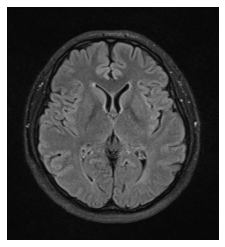

In [51]:
predict('TestModel/no_tumor.jpg',finalModel)

Input image shape is  (512, 512, 3)
the resized image has shape  (200, 200, 3)
image shape after expanding dimensions is  (1, 200, 200, 3)
1/1 [==============================] - 0s 312ms/step
the shape of prediction is  (1, 4)
the image is predicted as being glioma_tumor with a probability of  96.53 %


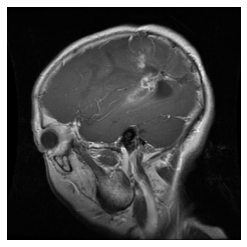

In [52]:
predict('TestModel/glioma_tumor.jpg',finalModel)

Input image shape is  (345, 338, 3)
the resized image has shape  (200, 200, 3)
image shape after expanding dimensions is  (1, 200, 200, 3)
1/1 [==============================] - 0s 274ms/step
the shape of prediction is  (1, 4)
the image is predicted as being meningioma_tumor with a probability of  96.17 %


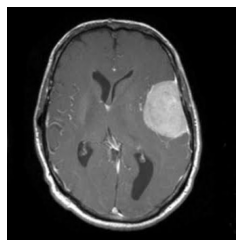

In [53]:
predict('TestModel/meningioma_tumor.jpg',finalModel)

Input image shape is  (512, 488, 3)
the resized image has shape  (200, 200, 3)
image shape after expanding dimensions is  (1, 200, 200, 3)
1/1 [==============================] - 0s 286ms/step
the shape of prediction is  (1, 4)
the image is predicted as being pituitary_tumor with a probability of  98.06 %


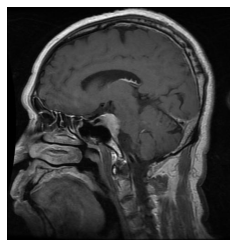

In [54]:
predict('TestModel/pituitary_tumor.jpg',finalModel)